In [46]:
!mkdir OCR_project

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [47]:
%cd /kaggle/working/OCR_project
!cp -r /kaggle/input/ocr-data/home/dhruvi/Simform/learning_project/combined_dataset .

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/kaggle/working/OCR_project


In [ ]:
!pip3 install bitsandbytes peft trl jiwer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
!pip install qwen-vl-utils[decord]==0.0.8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [50]:
#!pip uninstall torch torchvision torchaudio -y
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [51]:
import torch
print(torch.version.cuda)
print(torch.__file__)


12.4
/usr/local/lib/python3.11/dist-packages/torch/__init__.py


In [64]:
import os
os.environ["WANDB_DISABLED"] = "true"

# from datasets import load_dataset
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

import warnings
warnings.filterwarnings("ignore")

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
EPOCHS = 3
BATCH_SIZE = 1
GRADIENT_CHECKPOINTING = True,
USE_REENTRANT = False,
OPTIM = "paged_adamw_32bit"
LEARNING_RATE = 2e-5
LOGGING_STEPS = 50
EVAL_STEPS = 50
SAVE_STEPS = 50
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL="eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 1
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True}
REMOVE_UNUSED_COLUMNS = False
MAX_SEQ_LEN=3048
NUM_STEPS = (283 // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")

NUM_STEPS: 1415


In [79]:
# system_message = """You are a highly advanced Vision Language Model (VLM), specialized in extracting the text from historical documents. Extract the gujarati text from scanned historical document"""

system_message = """
You are a highly advanced Vision Language Model (VLM), specialized in extracting Gujarati text from scanned historical documents. 

Extract and return only the Gujarati text content, without any additional commentary, explanation, formatting, or headings. 

Your response should contain only the raw extracted Gujarati text no other details like system prompt and assistant details.
"""


In [68]:
import io
from PIL import Image
from io import BytesIO
import base64

In [69]:
def resize_image(image, max_size=(512, 512)):
    """
    Resize an image to a maximum size while maintaining aspect ratio.
    """
    image.thumbnail(max_size, Image.Resampling.LANCZOS)  # Updated here
    return image

def compress_image(image, quality=95):
    """
    Compress an image by reducing its quality.
    """
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    compressed_image = Image.open(buffer)
    return compressed_image

def preprocess_image(image, max_size=(812, 812), quality=85):
    """
    Preprocess an image by resizing and compressing it.
    """
    resized_image = resize_image(image, max_size)
    compressed_image = compress_image(resized_image, quality)
    return compressed_image

In [70]:
def format_data(sample,image_folder):
  # Preprocess the image
  file_name = sample["image"]
  image = Image.open(os.path.join(image_folder,sample["image"]))
  sample["image"] = preprocess_image(image)

  return {"filename" :file_name, "messages":[
      {
          "role": "system",
          "content": [{"type": "text", "text": system_message}],
      },
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": sample["image"],
              },
              {
                  "type": "text",
                  "text": "Extract gujarati text from the document images",
              },
              
          ],
      },
      {
          "role": "assistant",
          "content": [{"type": "text", "text": sample["text"]}],
      },
   ]}

## Prepare training data


In [71]:
import os
import json
from PIL import Image
from datasets import load_dataset, Dataset
from transformers import AutoProcessor, AutoModelForVision2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

# 1. Load and preprocess data
def load_jsonl(jsonl_path):
    samples = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            item = json.loads(line)
            samples.append({
                "image": item["image"],
                "text": item["text"]
            })
    return samples

data = load_jsonl("/kaggle/working/OCR_project/combined_dataset/anno_file.jsonl")
dataset = Dataset.from_list(data).train_test_split(test_size=0.1)

In [60]:
dataset['train'][0]

{'image': 'combined_dataset/images/375.jpg',
 'text': 'ઉપસંહાર\n\nસામાન્ય રીતે લોકો ટીકા સમીક્ષામાં નવી વાત શોધે છે, પરંતુ સત્ય તો\nસત્યજ છે. તે ન તો નવું હોય છે ન જૂનું. નવી વાતો તો અખબારોમાં છપાતી રહે\nછે, જે બનતી - ઘટતી ઘટનાઓ હોય છે. સત્ય તો અપરિવર્તનશીલ છે, આથી\nબીજું કોઈ કહે પણ શું ? જો કહે તો પછી તેણે કાંઈ પ્રાપ્ત નથી કર્યું. પ્રત્યેક મહાપુરુષ\nચાલીને તે લક્ષ્ય સુધી પહોંચી જશે તો એક જ વાત કહેશે. તે સમાજની વચ્ચે ફૂટ\nનહિ પાડી શકે. અગર એમ કહે તો પછી તેણે કાંઈ મેળવ્યું નથી એમ સાબિત\nથાય. શ્રીકૃષ્ણે પણ આજ સત્ય કહ્યું. જે સત્ય પૂર્વે મનીષીઓએ જોયું હતું. મેળવ્યું\nહતું અને ભવિષ્યમાં થનાર મહાપુરુષો પણ જો પ્રાપ્ત કરશે તો આ જ વાત કરશે.\n\nભહાપુરુષ અને તેમની કાર્યપ્રણાલી : મહાપુરુષ, દુનિયામાં સત્યને નામે\nપ્રસરેલી અને સત્ય જેવી લાગતી કુરીતિઓનું શમન કરીને કલ્યાણના પથ પર\nપુરસ્કૃત કરે છે. આ માર્ગ પણ દુનિયામાં પહેલેથી હોય છે. પરંતુ એની સમાંતર\nએના જેવા લાગતા અનેક માર્ગો પ્રચલિત થાય છે. એમાંથી વસ્તુતઃ સત્ય શું છે ?\nતે સત્ય શોધવું મુશ્કેલ બની જાય છે. પરંતુ મહાત્મા સત્યાનિઠ હોવાથી એમાંના\nસત્યન

In [72]:
# train_dataset, eval_dataset, test_dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1",
#                                                          split=["train[:1%]", "valid[:1%]"])
image_folder = "/kaggle/working/OCR_project"
train_dataset, eval_dataset = dataset['train'], dataset['test']

train_dataset = [format_data(sample,image_folder) for sample in train_dataset]
eval_dataset = [format_data(sample,image_folder) for sample in eval_dataset]
# test_dataset = [format_data(sample) for sample in test_dataset]

print(len(train_dataset))
print("-"*30)
print(train_dataset[0])
print("-"*30)
print(len(eval_dataset))
print("-"*30)
print(eval_dataset[0])

453
------------------------------
{'filename': 'combined_dataset/images/307.jpg', 'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': '\nYou are a highly advanced Vision Language Model (VLM), specialized in extracting Gujarati text from scanned historical documents. \n\nExtract and return only the Gujarati text content, without any additional commentary, explanation, formatting, or headings. \n\nYour response should contain only the raw extracted Gujarati text.\n'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=526x812 at 0x7FDFFC843CD0>}, {'type': 'text', 'text': 'Extract gujarati text from the document images'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'અધ્યાય પંદરમો ૩૦૭\n\nશરીરનો ત્યાગ કરતી વખતે જીવાત્મા મને તથા પાંચેય ઇન્દ્રિયોના\nકાર્ય-કલાપને સાથે લઈને જ નવા શરીરને ધારણ કરે છે. સંસ્કાર સાત્ત્વિક\nહોય તો તે સાત્ત્વિક કક્ષાએ પહોંચી જાય છે. રાજસી હોય તો મધ્યમ\nસ્થાન પર અને તામસી ર

Extract gujarati text from the document images
૧૧૦ યથાર્થ ગીતા

અકર્મની આ ક્ષમતા આવી જાય અને ધારાવાહિક કર્મો થતા રહે, ત્યારે જ
પરમ કલ્યાણની સ્થિતિ અપાવનારાં કર્મ થઈ જાય છે. “પૂજય મહારાજજી'
કહેતા હતા કે, “જ્યાં સુધી ઇષ્ટ રથી બની ને, રોકટોક ન કરવા લાગે ત્યાં
સુધી ઉચિત માત્રામાં સાધનની શરૂઆત જ નથી થતી.” આની પહેલાં જે
કાંઈ કરવામાં આવે છે, કર્મના પ્રવેશના પ્રયાસથી અધિક કંઈ જ નથી.
હળનો બધો ભાર બળદની કાંધ ઉપર જ હોય છે, છતાં પણ ખેતરની
વાવણી એ હળ ચલાવનારની દેન છે. ઠીક તે જ રીતે સાધનાનો બધો
ભાર સાધક ઉપર જ રહે છે, પરંતુ વાસ્તવિક સાધક તો ઇષ્ટ છે. જે એની
પાછળ લાગેલો છે, જે તેનું માર્ગદર્શન કરે છે. જ્યાં સુધી ઇષ્ટ નિર્ણય ન
આપે ત્યાં સુધી તમે સમજી નહિ શકો કે આપણાથી થયું છે શું ? આપણે
પ્રકૃતિમાં ભટકી રહ્યા છીએ કે પરમાત્મામાં ? આ રીતે ઇષ્ટના નિર્દેશનમાં
જે સાધક આત્મિક માર્ગ પર ચાલવા તત્પર છે, પોતાને અકર્તા સમજીને
એકધારું કર્મ કરે છે, તે જ બુદ્ધિમાન છે, તેનું જ્ઞાન યથાર્થ છે, તે જ યોગી
છે. જિજ્ઞાસા સ્વાભાવિક છે કે કર્મ કરતાં જ રહીશું કે ક્યારેય કર્મોથી
છુટકારો પણ મળશે ? આ વિષે યોગેશ્વર કહે છે --

શ્રી ક

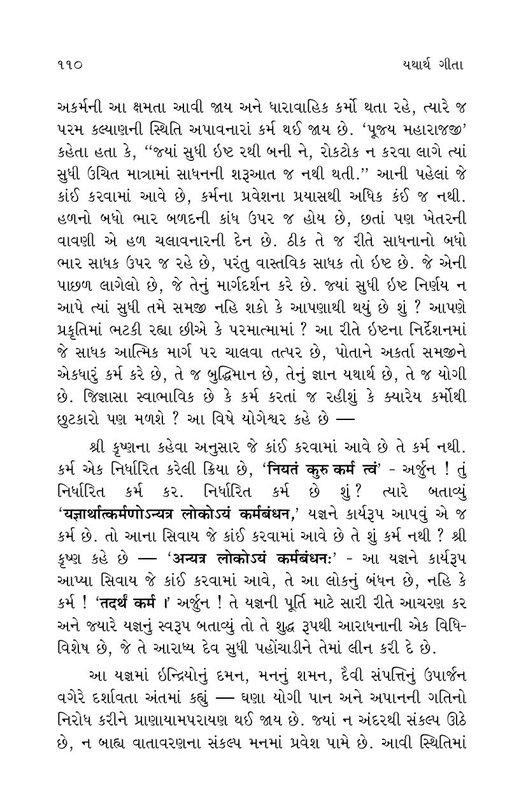

In [73]:
sample_data = eval_dataset[0]
# print( eval_dataset[0]['messages'])
sample_question = sample_data["messages"][1]["content"][1]["text"]
sample_image = sample_data["messages"][1]["content"][0]["image"]
sample_answer = sample_data["messages"][2]["content"][0]["text"]


print(sample_question)
print(sample_answer)
sample_image

# Inference before training


## Model loading

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_ID, torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"
# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

# messages = [
#     {
#         "role": "user",
#         "content": [
#             {
#                 "type": "image",
#                 "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
#             },
#             {"type": "text", "text": "Describe this image."},
#         ],
#     }
# ]

# # Preparation for inference
# text = processor.apply_chat_template(
#     messages, tokenize=False, add_generation_prompt=True
# )
# image_inputs, video_inputs = process_vision_info(messages)
# inputs = processor(
#     text=[text],
#     images=image_inputs,
#     videos=video_inputs,
#     padding=True,
#     return_tensors="pt",
# )
# inputs = inputs.to("cuda")

# # Inference: Generation of the output
# generated_ids = model.generate(**inputs, max_new_tokens=128)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text)


In [75]:
def text_generator(sample_data):
    text = processor.apply_chat_template(
        sample_data["messages"][0:2], tokenize=False, add_generation_prompt=True
    )

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs =  sample_data["messages"][1]["content"][0]["image"]

    inputs = processor(
        text=[text],
        images = image_inputs,
        return_tensors="pt"
    )
    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )
    del inputs
    actual_answer = sample_data["messages"][2]["content"][0]["text"]
    return output_text[0], actual_answer

In [ ]:
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

### batch inference

In [91]:

def run_inference(dataset):
    results = []

    for samples in dataset:
    
        try:
            predicted, actual = text_generator(samples)
            print(samples['filename'])
            # print("predictions++++++++",predicted)
            
            results.append({
                "image_file": samples['filename'],
                "predicted": predicted,
                "actual": actual
            })
        except Exception as e:
            print(f"Error at file: {e}")

    # Save to JSON
    with open("pretrained_qwen_inference_results.json", "w") as f:
        json.dump(results, f, indent=2)

    print("✅ Inference completed and saved to inference_results.json")    

In [93]:
run_inference(eval_dataset)

Prompt: <|im_start|>system

You are a highly advanced Vision Language Model (VLM), specialized in extracting Gujarati text from scanned historical documents. 

Extract and return only the Gujarati text content, without any additional commentary, explanation, formatting, or headings. 

Your response should contain only the raw extracted Gujarati text.
<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Extract gujarati text from the document images<|im_end|>
<|im_start|>assistant

------------------------------
combined_dataset/images/110.jpg
Prompt: <|im_start|>system

You are a highly advanced Vision Language Model (VLM), specialized in extracting Gujarati text from scanned historical documents. 

Extract and return only the Gujarati text content, without any additional commentary, explanation, formatting, or headings. 

Your response should contain only the raw extracted Gujarati text.
<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Extract g

## Model Fine-tuning

In [ ]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

In [ ]:
training_args = SFTConfig(
    output_dir="/kaggle/working/",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM,
)

In [ ]:
collate_sample = [train_dataset[0], train_dataset[1]] # for batch size 2.

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]
    image_inputs = [example[1]["content"][0]["image"] for example in examples]

    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = batch["input_ids"]

    return batch

collated_data = collate_fn(collate_sample)
print(collated_data.keys())

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

In [ ]:
print("Training")
trainer.train()
print("-"*30)

## Post-training evaluation


In [ ]:
import gc
import time

def clear_memory():
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()


## exp 1

In [ ]:
model.load_adapter("/content/drive/MyDrive/OCR_project/checkpoint-350")


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
trained_generated_text, trained_actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

## calculate WER and CER

In [ ]:
import jiwer

wer = jiwer.wer(trained_actual_answer, generated_text)
print("WER before:", wer)

wer = jiwer.wer(trained_actual_answer, trained_generated_text)
print("WER after:", wer)


In [ ]:
cer = jiwer.cer(trained_actual_answer, generated_text)
print("CER before:", cer)

cer = jiwer.cer(trained_actual_answer, trained_generated_text)
print("CER after:", cer)


## exp 2

In [ ]:
model.load_adapter("/content/drive/MyDrive/OCR_project/checkpoint-300")


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
trained_generated_text, trained_actual_answer = text_generator(sample_data)
print(f"Generated Answer: {trained_generated_text}")
print(f"Actual Answer: {trained_actual_answer}")

In [ ]:
import jiwer


wer = jiwer.wer(trained_actual_answer, generated_text)
print("WER before:", wer)

wer = jiwer.wer(trained_actual_answer, trained_generated_text)
print("WER after:", wer)


In [ ]:
cer = jiwer.cer(trained_actual_answer, generated_text)
print("CER before:", cer)

cer = jiwer.cer(trained_actual_answer, trained_generated_text)
print("CER after:", cer)
